/var/folders/wt/235r931j41l69xvzx6fk265r0000gn/T/ipykernel_14844/1431715946.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


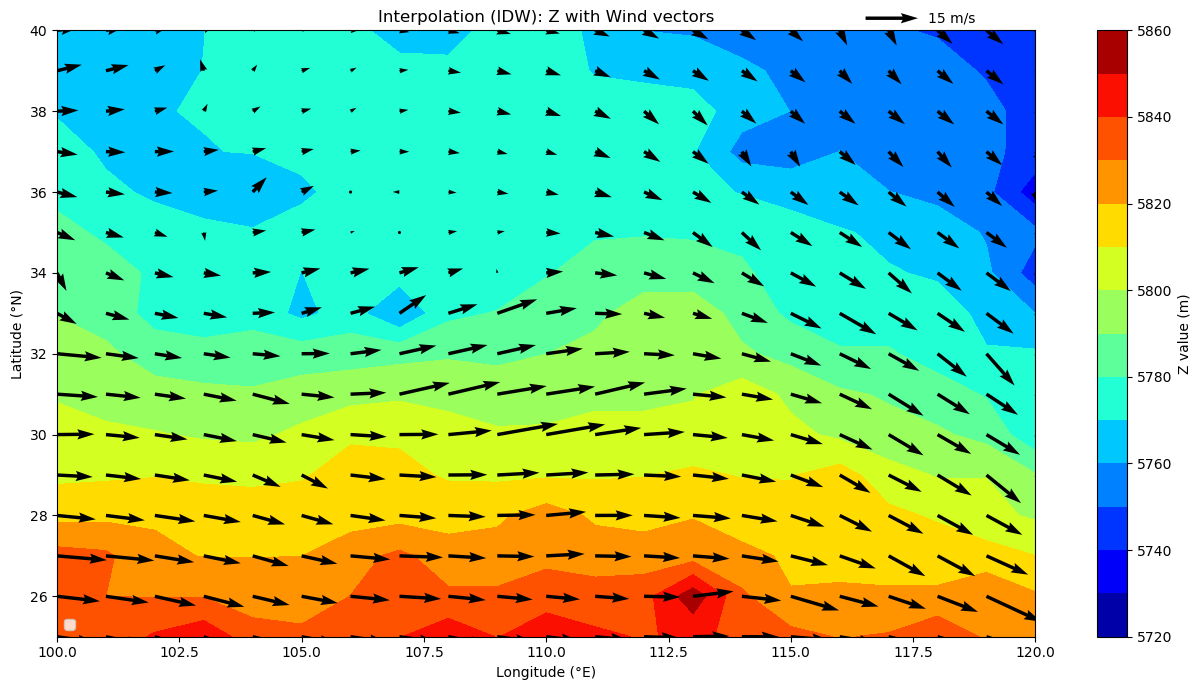

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取数据 ===
# 文件格式: 经度 纬度 Z 风速 风向
data = pd.read_csv('data.txt', sep='\t', header=None,
                   names=['lon','lat','Z','wind_speed','wind_dir'])

# 转为 numpy 数组
lons = data['lon'].values
lats = data['lat'].values
Z = data['Z'].values

# 计算风矢量分量（气象学：风来自的方向）
spd = data['wind_speed'].values.astype(float)
dir_deg = data['wind_dir'].values.astype(float)
theta = np.deg2rad(dir_deg)
u = -spd * np.sin(theta)
v = -spd * np.cos(theta)

# === 2. 定义插值区域 ===
lon_grid = np.arange(100, 121, 1)
lat_grid = np.arange(25, 41, 1)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# === 3. 定义IDW插值函数 ===
def idw_interpolation(x, y, z, xi, yi):
    """
    基于公式：
        f_g = Σ(f_i * w_i) / Σ(w_i)
        w_i = 1 / (1 + r_i^2)
        r_i: 站点到格点的距离（此处用等经纬近似算距, 单位 km）
    """
    R = 6371.0
    # 等经纬近似：把经差按该纬度缩放
    dlon = (x - xi) * np.cos(np.deg2rad(yi))
    dlat = (y - yi)
    # 角度->弧度，弧度*R = km
    dist_km = np.sqrt(dlon**2 + dlat**2) * np.pi/180.0 * R
    w = 1.0 / (1.0 + dist_km**2)
    sw = w.sum()
    if sw == 0:
        return np.nan
    return np.sum(w * z) / sw

# === 4. 逐点插值 ===
Z_interp = np.zeros_like(lon_mesh, dtype=float)
U_interp = np.zeros_like(lon_mesh, dtype=float)
V_interp = np.zeros_like(lon_mesh, dtype=float)

for i in range(lat_mesh.shape[0]):
    for j in range(lon_mesh.shape[1]):
        Z_interp[i, j] = idw_interpolation(lons, lats, Z, lon_mesh[i, j], lat_mesh[i, j])
        U_interp[i, j] = idw_interpolation(lons, lats, u, lon_mesh[i, j], lat_mesh[i, j])
        V_interp[i, j] = idw_interpolation(lons, lats, v, lon_mesh[i, j], lat_mesh[i, j])


# === 5. 绘制结果（叠加风矢量） ===
levels = np.arange(5720, 5860 + 1, 10)

plt.figure(figsize=(13,7))
cont = plt.contourf(lon_mesh, lat_mesh, Z_interp, levels=levels, cmap='jet')
cb = plt.colorbar(cont, label='Z value (m)', extend='both')
# 站点散点
# plt.scatter(lons, lats, c='k', s=12, label='Stations', zorder=3)

# 站点风矢量（用风速着色）
# Q = plt.quiver(
#     lons, lats, u, v, spd,         # U, V 分量和用来着色的风速
#     scale_units='xy', angles='xy', # 在经纬度坐标下按“坐标单位”解释
#     scale=10,                      # 适当调整箭头长度尺度（可改大/改小）
#     width=0.0035,                  # 箭杆粗细
#     zorder=4, cmap='viridis'
# )

Q = plt.quiver(
    lon_mesh, lat_mesh, U_interp, V_interp,         # U, V 分量和用来着色的风速
    scale_units='xy', angles='xy', # 在经纬度坐标下按“坐标单位”解释
    scale=14,                      # 适当调整箭头长度尺度（可改大/改小）
    width=0.0035,                  # 箭杆粗细
    zorder=4
)
# quiver 图例（风速参考）
plt.quiverkey(Q, X=0.88, Y=1.02, U=15, label='15 m/s', labelpos='E')  

plt.xlim(100, 120)
plt.ylim(25, 40)
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.title('Interpolation (IDW): Z with Wind vectors')
plt.legend(loc='lower left')

# 单独加一个风速色条（对应箭头颜色）
# cbar = plt.colorbar(Q, pad=0.015)
# cbar.set_label('Wind speed (m/s)')

plt.tight_layout()
plt.show()